# 1. Implement Policy Evaluation in Python (Gridworld)

In [1]:
import numpy as np
from lib.envs.gridworld import GridworldEnv
import matplotlib.pyplot as plt 

In [2]:
env = GridworldEnv()

In [3]:

def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for ns in range(env.nS):
            v = 0
            for a, p_act in enumerate(policy[ns]):
                for p_dyn, next_state, r, done in env.P[ns][a]:
                    v += p_act * p_dyn * (r + discount_factor * V[next_state]) # following page 75

            delta = max(delta, abs(v - V[ns]))
            V[ns] = v
        if delta < theta: 
            break
    return np.array(V)

In [4]:
random_policy = np.ones([env.nS, env.nA]) / env.nA
v = policy_eval(random_policy, env)

In [5]:
v.reshape(env.shape)

array([[  0.        , -13.99993529, -19.99990698, -21.99989761],
       [-13.99993529, -17.9999206 , -19.99991379, -19.99991477],
       [-19.99990698, -19.99991379, -17.99992725, -13.99994569],
       [-21.99989761, -19.99991477, -13.99994569,   0.        ]])

In [6]:
expected_v = np.array([0, -14, -20, -22, -14, -18, -20, -20, -20, -20, -18, -14, -22, -20, -14, 0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)

# 2. Implement Policy Iteration in Python (Gridworld)

In [7]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    while True:
        # Policy evaluation
        V = policy_eval(policy, env, discount_factor)
        policy_stable = True

        for ns in range(env.nS):
            old_action = np.argmax(policy[ns])
            va = np.zeros(env.nA)
            for a in range(env.nA):
                for p_dyn, next_state, r, done in env.P[ns][a]:
                    va[a] =  p_dyn * (r + discount_factor * V[next_state]) # value of each action+
            new_action = np.argmax(va)
            policy[ns] = np.eye(env.nA)[new_action]
            if old_action !=  new_action:
                policy_stable = False
        if policy_stable:
            break
    
    return policy, V

In [8]:
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



In [9]:
# Test the value function
expected_v = np.array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)

# 3. Implement Value Iteration in Python (Gridworld)

In [10]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    

    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])
    
    while True:
        delta = 0
        for ns in range(env.nS):
            va = np.zeros(env.nA)
            for a in range(env.nA):
                for p_dyn, next_state, r, done in env.P[ns][a]:
                    va[a] = p_dyn * (r + discount_factor * V[next_state]) 
            v = max(va)
            delta = max(delta, abs(v - V[ns]))
            V[ns] = v
            policy[ns] = np.eye(env.nA)[np.argmax(va)]
        if delta < theta: 
            break
    return policy, V

In [11]:

policy, v = value_iteration(env)

print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



In [12]:
# Test the value function
expected_v = np.array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)

# 4. Implement Gambler's Problem

* State is the gambler's capital, $s \in {1,2,...,99}$
* Actions are stakes, $a \in {0,1,2,...,\min(s,100-s)}$ 
* Reward 0 until +100 (+1) of capital
* State value function gives the probability of winning from each state
* The policy is the mapping from,levels of capital (states) to stakes (actions) 
* p_h is the probability of comming up heads (when the player wins) 

### Implement value iteration for the gambler's problem and solve it for p_h = 0.25 and p_0.55

In [13]:
def value_iteration_for_gamblers(p_h, theta=0.0001, discount_factor=1.0):
    """
    Args:
        p_h: Probability of the coin coming up heads
    """
    
    policy = np.zeros(100)
    rewards = np.zeros(101)
    rewards[-1] = 1
    V = np.zeros(101)
    while True:
        delta = 0
        for ns in range(1, 100):
            va = np.zeros(101)
            for a in range(0, min(ns, 100-ns)+1):
                    # rewards[s+a] (win), and rewards[s - a] (loose) are immediate rewards
                    # v[s+a] (win), v[s - a] (loose) are the values of the next states
                va[a] = p_h * (rewards[ns + a] + discount_factor * V[ns + a]) + (1 - p_h) * (rewards[ns - a] + discount_factor * V[ns - a])
            v = max(va)
            delta = max(delta, abs(v- V[ns]))
            V[ns] = v
            policy[ns] = np.argmax(va)
        if delta < theta:
            return policy, V

In [14]:
policy, V = value_iteration_for_gamblers(0.25)

In [15]:
policy

array([ 0.,  1.,  0.,  3.,  4.,  0.,  0.,  7.,  8.,  0., 10., 11.,  0.,
       12., 11.,  0.,  9.,  0.,  7.,  6.,  0.,  0.,  3.,  0.,  0.,  0.,
        0.,  2.,  0.,  4.,  5.,  0.,  7.,  8.,  9.,  0., 11.,  0.,  0.,
        0., 10.,  9.,  8.,  7.,  0.,  5.,  4.,  0.,  2.,  1.,  0.,  0.,
        2.,  0.,  4.,  5.,  0.,  7.,  8.,  9.,  0., 11.,  0.,  0.,  0.,
       10.,  9.,  8.,  7.,  0.,  5.,  4.,  0.,  2.,  1.,  0.,  1.,  2.,
        0.,  4.,  0.,  0.,  0.,  8.,  9., 10.,  0., 12., 12.,  0.,  0.,
        0.,  8.,  0.,  6.,  0.,  4.,  3.,  2.,  1.])

In [16]:
V

array([0.00000000e+00, 7.24792480e-05, 2.89916992e-04, 6.95257448e-04,
       1.16010383e-03, 1.76906586e-03, 2.78102979e-03, 4.03504074e-03,
       4.66214120e-03, 5.59997559e-03, 7.08471239e-03, 9.03964043e-03,
       1.11241192e-02, 1.56793594e-02, 1.61464431e-02, 1.69517994e-02,
       1.86512806e-02, 1.98249817e-02, 2.24047303e-02, 2.73845196e-02,
       2.83388495e-02, 3.04937363e-02, 3.61633897e-02, 3.84953022e-02,
       4.44964767e-02, 6.25000000e-02, 6.27174377e-02, 6.33700779e-02,
       6.45857723e-02, 6.59966059e-02, 6.78135343e-02, 7.08430894e-02,
       7.46098323e-02, 7.64884604e-02, 7.93035477e-02, 8.37541372e-02,
       8.96225423e-02, 9.58723575e-02, 1.09538078e-01, 1.10939329e-01,
       1.13360151e-01, 1.18457374e-01, 1.21977661e-01, 1.29716907e-01,
       1.44653559e-01, 1.47520113e-01, 1.53983246e-01, 1.70990169e-01,
       1.77987434e-01, 1.95990576e-01, 2.50000000e-01, 2.50217438e-01,
       2.50870078e-01, 2.52085772e-01, 2.53496606e-01, 2.55313534e-01,
      

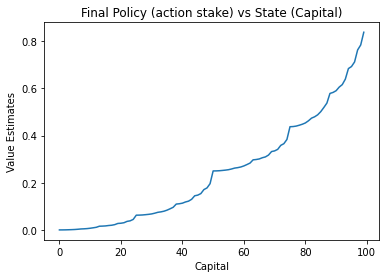

In [17]:
# Plotting Final Policy (action stake) vs State (Capital)

# x axis values
x = range(100)
# corresponding y axis values
y = V[:100]
 
# plotting the points 
plt.plot(x, y)
 
# naming the x axis
plt.xlabel('Capital')
# naming the y axis
plt.ylabel('Value Estimates')
 
# giving a title to the graph
plt.title('Final Policy (action stake) vs State (Capital)')
 
# function to show the plot
plt.show()

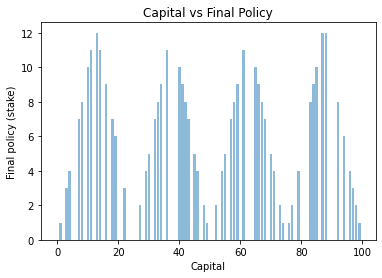

In [18]:
# Plotting Capital vs Final Policy

# x axis values
x = range(100)
# corresponding y axis values
y = policy
 
# plotting the bars
plt.bar(x, y, align='center', alpha=0.5)
 
# naming the x axis
plt.xlabel('Capital')
# naming the y axis
plt.ylabel('Final policy (stake)')
 
# giving a title to the graph
plt.title('Capital vs Final Policy')
 
# function to show the plot
plt.show()